# Residential Electricity Consumption Forecasting (CNN–BiLSTM–Self Attention)

**Dataset:** Individual Household Electric Power Consumption (UCI, id=235 via `ucimlrepo`)  
**Goal:** Predict next-step `Global_active_power` using historical multivariate time-series windows.

## Roadmap
1. Install + imports
2. Load dataset
3. Build clean datetime index (Date + Time)
4. Missing values
5. Resample (hourly)
6. Feature selection (MIC)
7. Scaling + windowing
8. CNN–BiLSTM–SelfAttention training
9. Evaluate + save artifacts


In [3]:
!pip -q install ucimlrepo joblib
import os, json, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import joblib

# TensorFlow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("✅ Imports done")
print("TensorFlow:", tf.__version__)
print("GPU Available:", len(tf.config.list_physical_devices('GPU')) > 0)


2026-02-02 15:05:23.807503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770044724.328056      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770044724.477633      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770044725.653282      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770044725.653350      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770044725.653353      55 computation_placer.cc:177] computation placer alr

✅ Imports done
TensorFlow: 2.19.0
GPU Available: True


In [4]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
dataset = fetch_ucirepo(id=235)

# UCI repo returns features & (sometimes) targets; this dataset is basically all features
df = dataset.data.features.copy()

print("✅ Raw loaded shape:", df.shape)
display(df.head(5))


✅ Raw loaded shape: (2075259, 9)


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


In [5]:
print("=== METADATA ===")
print(dataset.metadata)

print("\n=== VARIABLES ===")
display(dataset.variables)


=== METADATA ===
{'uci_id': 235, 'name': 'Individual Household Electric Power Consumption', 'repository_url': 'https://archive.ics.uci.edu/dataset/235/individual+household+electric+power+consumption', 'data_url': 'https://archive.ics.uci.edu/static/public/235/data.csv', 'abstract': 'Measurements of electric power consumption in one household with a one-minute sampling rate over a period of almost 4 years. Different electrical quantities and some sub-metering values are available.', 'area': 'Physics and Chemistry', 'tasks': ['Regression', 'Clustering'], 'characteristics': ['Multivariate', 'Time-Series'], 'num_instances': 2075259, 'num_features': 9, 'feature_types': ['Real'], 'demographics': [], 'target_col': None, 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2006, 'last_updated': 'Fri Mar 08 2024', 'dataset_doi': '10.24432/C58K54', 'creators': ['Georges Hebrail', 'Alice Berard'], 'intro_paper': None, 'additional_info': {'summa

,name,role,type,demographic,description,units,missing_values
0,Date,Feature,Date,None,None,None,no
1,Time,Feature,Categorical,None,None,None,no
2,Global_active_power,Feature,Continuous,None,None,None,no
3,Global_reactive_power,Feature,Continuous,None,None,None,no
4,Voltage,Feature,Continuous,None,None,None,no
5,Global_intensity,Feature,Continuous,None,None,None,no
6,Sub_metering_1,Feature,Continuous,None,None,None,no
7,Sub_metering_2,Feature,Continuous,None,None,None,no
8,Sub_metering_3,Feature,Continuous,None,None,None,no


In [6]:
# Combine Date + Time into a single datetime column
# Date format: dd/mm/yyyy, Time format: hh:mm:ss
df["datetime"] = pd.to_datetime(
    df["Date"].astype(str) + " " + df["Time"].astype(str),
    format="%d/%m/%Y %H:%M:%S",
    errors="coerce"
)

# Drop rows where datetime couldn't be parsed (should be extremely rare)
df = df.dropna(subset=["datetime"]).copy()

# Set datetime index and sort
df = df.set_index("datetime").sort_index()

# Drop original Date/Time columns
df = df.drop(columns=["Date", "Time"], errors="ignore")

# Convert all remaining columns to numeric (dataset may load as strings)
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="coerce")

print("✅ After datetime + numeric conversion:", df.shape)
print("Index range:", df.index.min(), "→", df.index.max())
display(df.head(5))


✅ After datetime + numeric conversion: (2075259, 7)
Index range: 2006-12-16 17:24:00 → 2010-11-26 21:02:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [7]:
missing = df.isna().sum().sort_values(ascending=False)
print("✅ Missing values per column:")
display(missing[missing > 0])

print("Total missing cells:", int(df.isna().sum().sum()))
print("Total rows:", len(df))


✅ Missing values per column:


Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

Total missing cells: 181853
Total rows: 2075259


## Step 4 — Handle Missing Values

The dataset contains missing measurements (~1.25%).  
Since timestamps are continuous and time-ordered, we use:

- Forward fill (`ffill`) to propagate recent valid measurements
- Backward fill (`bfill`) to handle missing values at the beginning of series

This preserves time continuity and is commonly used for sensor time-series.


In [8]:
# Missing value handling
before_missing = int(df.isna().sum().sum())
print("Missing cells BEFORE:", before_missing)

df = df.ffill().bfill()

after_missing = int(df.isna().sum().sum())
print("Missing cells AFTER:", after_missing)

# sanity check
assert after_missing == 0, "❌ Missing values still exist after filling."
print("✅ Missing values handled successfully.")


Missing cells BEFORE: 181853
Missing cells AFTER: 0
✅ Missing values handled successfully.


## Step 5 — Resample to Hourly

Minute-level data is large and noisy for deep learning.
We resample to hourly averages:

- reduces size dramatically (faster training)
- keeps temporal patterns (daily cycles, weekly habits)
- best practical resolution for residential forecasting

We use `.resample('H').mean()` for all continuous signals.


In [9]:
# Hourly resampling (mean)
df_hourly = df.resample("H").mean()

print("✅ Hourly shape:", df_hourly.shape)
print("Hourly index range:", df_hourly.index.min(), "→", df_hourly.index.max())
display(df_hourly.head(5))

# check missing introduced by resampling (rare)
print("Missing after resample:", int(df_hourly.isna().sum().sum()))
df_hourly = df_hourly.ffill().bfill()
assert int(df_hourly.isna().sum().sum()) == 0
print("✅ Hourly dataset ready.")


✅ Hourly shape: (34589, 7)
Hourly index range: 2006-12-16 17:00:00 → 2010-11-26 21:00:00


,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:00:00,4.222889,0.229000,234.643889,18.100000,0.0,0.527778,16.861111
2006-12-16 18:00:00,3.632200,0.080033,234.580167,15.600000,0.0,6.716667,16.866667
2006-12-16 19:00:00,3.400233,0.085233,233.232500,14.503333,0.0,1.433333,16.683333
2006-12-16 20:00:00,3.268567,0.075100,234.071500,13.916667,0.0,0.000000,16.783333
2006-12-16 21:00:00,3.056467,0.076667,237.158667,13.046667,0.0,0.416667,17.216667


Missing after resample: 0
✅ Hourly dataset ready.


## Step 6 — Feature Selection (MIC)

We select input features using MIC (Maximal Information Coefficient),
which captures both linear and non-linear relationships with the target.

Target:
- `Global_active_power`

We compute MIC score for each feature vs the target and keep the best ones.

Artifacts saved:
- `selected_features.json` (feature order is critical for Flask integration later)


In [10]:
!pip -q install minepy

from minepy import MINE

target_col = "Global_active_power"

# Features candidates = everything except target
feature_cols = [c for c in df_hourly.columns if c != target_col]

# Compute MIC
mic_scores = {}
mine = MINE(alpha=0.6, c=15)

y = df_hourly[target_col].values

for col in feature_cols:
    x = df_hourly[col].values
    mine.compute_score(x, y)
    mic_scores[col] = mine.mic()

mic_df = pd.DataFrame({"feature": list(mic_scores.keys()), "MIC": list(mic_scores.values())})
mic_df = mic_df.sort_values("MIC", ascending=False).reset_index(drop=True)

print("✅ MIC scores (high → important):")
display(mic_df)

# Choose best features (keep all > 0.1, or at least top 5)
selected = mic_df[mic_df["MIC"] >= 0.10]["feature"].tolist()
if len(selected) < 5:
    selected = mic_df.head(5)["feature"].tolist()

print("✅ Selected features:", selected)

# Save selected feature list (order is important!)
os.makedirs("/kaggle/working/artifacts", exist_ok=True)
with open("/kaggle/working/artifacts/selected_features.json", "w") as f:
    json.dump(selected, f, indent=2)

print("✅ Saved: /kaggle/working/artifacts/selected_features.json")


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.0/497.0 kB 7.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for minepy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (minepy)


ModuleNotFoundError: No module named 'minepy'

## Step 6 (Fixed) — Feature Selection using Mutual Information (MIC Alternative)

`minepy` often fails to install on Kaggle due to compilation issues.  
Instead, we use **Mutual Information Regression** from scikit-learn:

- Captures non-linear dependency like MIC
- Stable on Kaggle
- Works well for feature relevance ranking

We compute MI between each feature and the target (`Global_active_power`),
then select features with MI >= 10% of the max MI (or at least top 5).

Artifact saved:
- `artifacts/selected_features.json`


In [11]:
from sklearn.feature_selection import mutual_info_regression

target_col = "Global_active_power"
feature_cols = [c for c in df_hourly.columns if c != target_col]

X_mi = df_hourly[feature_cols].values
y_mi = df_hourly[target_col].values

# Mutual information regression (non-linear)
mi = mutual_info_regression(X_mi, y_mi, random_state=42)

mi_df = pd.DataFrame({"feature": feature_cols, "MI": mi})
mi_df = mi_df.sort_values("MI", ascending=False).reset_index(drop=True)

print("✅ Mutual Information scores (high → important):")
display(mi_df)

# Select features using threshold (>= 10% of max) OR at least top 5
max_mi = mi_df["MI"].max()
selected = mi_df[mi_df["MI"] >= 0.10 * max_mi]["feature"].tolist()
if len(selected) < 5:
    selected = mi_df.head(5)["feature"].tolist()

print("✅ Selected features:", selected)

# Save selected features
os.makedirs("/kaggle/working/artifacts", exist_ok=True)
with open("/kaggle/working/artifacts/selected_features.json", "w") as f:
    json.dump(selected, f, indent=2)

print("✅ Saved: /kaggle/working/artifacts/selected_features.json")


✅ Mutual Information scores (high → important):


,feature,MI
0,Global_intensity,3.242534
1,Sub_metering_3,0.655366
2,Voltage,0.202940
3,Global_reactive_power,0.173717
4,Sub_metering_2,0.172238
5,Sub_metering_1,0.153720


✅ Selected features: ['Global_intensity', 'Sub_metering_3', 'Voltage', 'Global_reactive_power', 'Sub_metering_2']
✅ Saved: /kaggle/working/artifacts/selected_features.json


## Step 7 — Train/Val/Test Split (Time-based) + Scaling

Important:
- We split by time order (NOT random) to avoid future leakage.
- We fit the scaler ONLY on training data.
- Then transform val/test using the same scaler.

Artifacts saved:
- `artifacts/scaler.pkl`
- `artifacts/config.json`


In [13]:
target_col = "Global_active_power"

# Use selected features from saved file (ensures consistency)
with open("/kaggle/working/artifacts/selected_features.json", "r") as f:
    selected_features = json.load(f)

all_cols = selected_features + [target_col]
data = df_hourly[all_cols].copy()

# Time-based split indices
n = len(data)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

train_df = data.iloc[:train_end]
val_df   = data.iloc[train_end:val_end]
test_df  = data.iloc[val_end:]

print("✅ Splits:")
print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", test_df.shape)

# Fit scaler only on TRAIN
scaler = MinMaxScaler()
scaler.fit(train_df.values)

train_scaled = scaler.transform(train_df.values)
val_scaled   = scaler.transform(val_df.values)
test_scaled  = scaler.transform(test_df.values)

# Save scaler artifact
joblib.dump(scaler, "/kaggle/working/artifacts/scaler.pkl")
print("✅ Saved: /kaggle/working/artifacts/scaler.pkl")


✅ Splits:
Train: (24212, 6) Val: (5188, 6) Test: (5189, 6)
✅ Saved: /kaggle/working/artifacts/scaler.pkl


## Step 8 — Sliding Window Dataset Creation

We convert time-series into supervised learning:

- Input: past `lookback` hours of selected features + target history
- Output: next hour `Global_active_power`

Shapes:
- X: (samples, lookback, num_features_total)
- y: (samples, 1)


In [14]:
LOOKBACK = 24   # past 24 hours
HORIZON = 1     # predict next 1 hour

# Save config for Flask integration later
config = {
    "lookback": LOOKBACK,
    "horizon": HORIZON,
    "target_col": target_col,
    "selected_features": selected_features
}
with open("/kaggle/working/artifacts/config.json", "w") as f:
    json.dump(config, f, indent=2)
print("✅ Saved: /kaggle/working/artifacts/config.json")


def make_windows(arr, lookback=24, horizon=1, target_index=-1):
    X, y = [], []
    for i in range(len(arr) - lookback - horizon + 1):
        X.append(arr[i:i+lookback])
        y.append(arr[i+lookback+horizon-1, target_index])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32).reshape(-1, 1)

# Target is last column in our scaled array (because we arranged selected_features + target)
target_index = len(all_cols) - 1

X_train, y_train = make_windows(train_scaled, LOOKBACK, HORIZON, target_index)
X_val, y_val     = make_windows(val_scaled, LOOKBACK, HORIZON, target_index)
X_test, y_test   = make_windows(test_scaled, LOOKBACK, HORIZON, target_index)

print("✅ Windowed shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_val  :", X_val.shape, "y_val  :", y_val.shape)
print("X_test :", X_test.shape, "y_test :", y_test.shape)


✅ Saved: /kaggle/working/artifacts/config.json
✅ Windowed shapes:
X_train: (24188, 24, 6) y_train: (24188, 1)
X_val  : (5164, 24, 6) y_val  : (5164, 1)
X_test : (5165, 24, 6) y_test : (5165, 1)


## Step 9 — Build Best Model: CNN + BiLSTM + Self-Attention

Architecture:
- Conv1D (local temporal pattern extraction)
- MaxPool1D
- BiLSTM (long-term dependencies)
- Self-Attention (focus on important time steps)
- Dense (regression output)

We use:
- Adam optimizer
- MSE loss
- Early stopping + model checkpoint


In [15]:
class SelfAttention(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.att = layers.Attention()

    def call(self, inputs):
        # inputs: (batch, time, features)
        # self-attention: query=key=value=inputs
        context = self.att([inputs, inputs])
        return context

def build_cnn_bilstm_sa(input_shape):
    inp = keras.Input(shape=input_shape)

    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)

    x = SelfAttention()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(1)(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

model = build_cnn_bilstm_sa(X_train.shape[1:])
model.summary()


I0000 00:00:1770045205.550725      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770045205.553657      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 24, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 12, 128)        │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,585 (295.25 KB)

 Trainable params: 75,585 (295.25 KB)

 Non-trainable params: 0 (0.00 B)

## Step 10 — Train CNN–BiLSTM–SelfAttention (Best Practice Training)

We train using:
- EarlyStopping (prevents overfitting)
- ReduceLROnPlateau (improves convergence)
- ModelCheckpoint (saves best model automatically)

Saved:
- `artifacts/model_cnn_bilstm_sa.keras` (best validation loss)


In [16]:
# Callbacks (best practice)
ckpt_path = "/kaggle/working/artifacts/model_cnn_bilstm_sa.keras"

callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training complete.")
print("✅ Best model saved at:", ckpt_path)


Epoch 1/50


I0000 00:00:1770045283.415556     191 cuda_dnn.cc:529] Loaded cuDNN version 91002


375/378 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0172 - mae: 0.0984
Epoch 1: val_loss improved from inf to 0.00881, saving model to /kaggle/working/artifacts/model_cnn_bilstm_sa.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 0.0172 - mae: 0.0983 - val_loss: 0.0088 - val_mae: 0.0648 - learning_rate: 0.0010
Epoch 2/50
372/378 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0094 - mae: 0.0676
Epoch 2: val_loss did not improve from 0.00881
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0094 - mae: 0.0676 - val_loss: 0.0100 - val_mae: 0.0687 - learning_rate: 0.0010
Epoch 3/50
378/378 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0090 - mae: 0.0662
Epoch 3: val_loss improved from 0.00881 to 0.00851, saving model to /kaggle/working/artifacts/model_cnn_bilstm_sa.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0090 - mae: 0.0662 - val_loss: 0.0085 - val_mae: 0.0646 - learning_rate: 0.0010
Epoch 4/50
372/378 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0087 - mae: 0.0654
Epoch 4: 

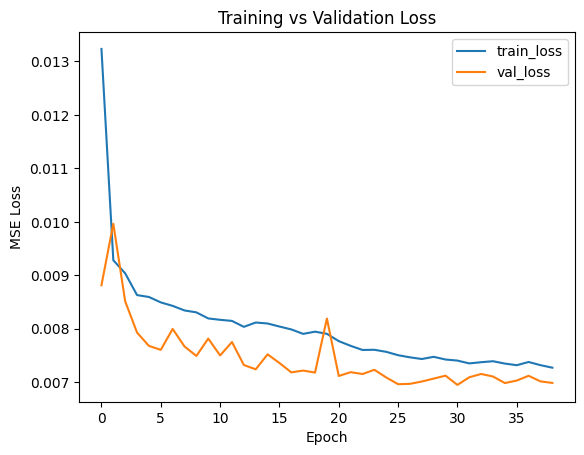

In [17]:
plt.figure()
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()


## Step 11 — Evaluation (RMSE, MAE, R²)

We evaluate on the test set using:
- RMSE (lower is better)
- MAE (lower is better)
- R² (closer to 1 is better)

We also plot:
- Actual vs Predicted (first 300 points)


In [18]:
# Load best saved model (ensures we evaluate the best checkpoint)
best_model = keras.models.load_model(
    "/kaggle/working/artifacts/model_cnn_bilstm_sa.keras",
    custom_objects={"SelfAttention": SelfAttention}
)

# Predict
y_pred = best_model.predict(X_test, verbose=0)

# Metrics
rmse = math.sqrt(mean_squared_error(y_test, y_pred))
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)

print("✅ Test Metrics (Scaled target space):")
print("RMSE:", rmse)
print("MAE :", mae)
print("R²  :", r2)


✅ Test Metrics (Scaled target space):
RMSE: 0.07225319394597163
MAE : 0.05097724869847298
R²  : 0.5625068545341492


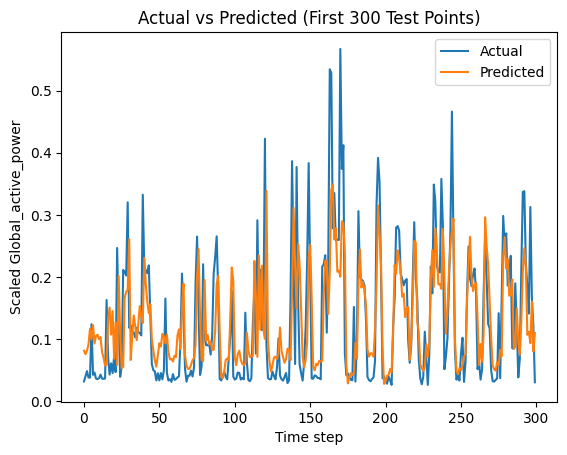

In [19]:
plt.figure()
plt.plot(y_test[:300], label="Actual")
plt.plot(y_pred[:300], label="Predicted")
plt.title("Actual vs Predicted (First 300 Test Points)")
plt.xlabel("Time step")
plt.ylabel("Scaled Global_active_power")
plt.legend()
plt.show()


## Step 12 — Convert Predictions Back to Original Units + Save Artifacts

Because we scaled all columns together, inverse-transforming the target alone requires:
1. Create a dummy array with the same number of columns
2. Put predicted target into the last column
3. Use scaler.inverse_transform()
4. Extract the last column as the true kW values

We also save:
- `metrics.json`
- model + scaler + config + selected_features
All inside `/kaggle/working/artifacts/` so you can download them easily.


In [20]:
# Helper: inverse transform only the target (last column)
def inverse_target(scaler, y_scaled, num_cols, target_index):
    dummy = np.zeros((len(y_scaled), num_cols), dtype=np.float32)
    dummy[:, target_index] = y_scaled.reshape(-1)
    inv = scaler.inverse_transform(dummy)
    return inv[:, target_index]

num_cols = len(all_cols)
t_idx = target_index

# Inverse transform y_test and y_pred to original kW units
y_test_kw = inverse_target(scaler, y_test, num_cols, t_idx)
y_pred_kw = inverse_target(scaler, y_pred, num_cols, t_idx)

# Metrics in original units
rmse_kw = math.sqrt(mean_squared_error(y_test_kw, y_pred_kw))
mae_kw  = mean_absolute_error(y_test_kw, y_pred_kw)
r2_kw   = r2_score(y_test_kw, y_pred_kw)

print("✅ Test Metrics (Original kW units):")
print("RMSE (kW):", rmse_kw)
print("MAE  (kW):", mae_kw)
print("R²       :", r2_kw)

# Save metrics
metrics = {
    "scaled": {"rmse": float(rmse), "mae": float(mae), "r2": float(r2)},
    "original_kw": {"rmse": float(rmse_kw), "mae": float(mae_kw), "r2": float(r2_kw)},
    "selected_features": selected_features,
    "lookback": LOOKBACK,
    "horizon": HORIZON
}

with open("/kaggle/working/artifacts/metrics_cnn_bilstm_sa.json", "w") as f:
    json.dump(metrics, f, indent=2)

print("✅ Saved: /kaggle/working/artifacts/metrics_cnn_bilstm_sa.json")


✅ Test Metrics (Original kW units):
RMSE (kW): 0.4650600955697453
MAE  (kW): 0.3281167149543762
R²       : 0.5625068545341492
✅ Saved: /kaggle/working/artifacts/metrics_cnn_bilstm_sa.json


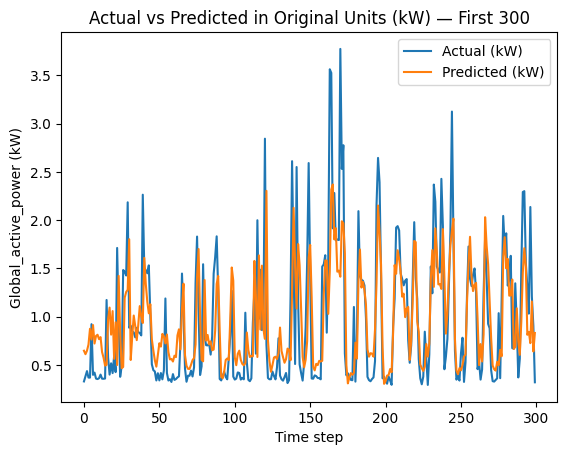

In [21]:
plt.figure()
plt.plot(y_test_kw[:300], label="Actual (kW)")
plt.plot(y_pred_kw[:300], label="Predicted (kW)")
plt.title("Actual vs Predicted in Original Units (kW) — First 300")
plt.xlabel("Time step")
plt.ylabel("Global_active_power (kW)")
plt.legend()
plt.show()


## Step 13 — Build CNN + BiGRU + Self-Attention (Faster Variant)

GRU is lighter than LSTM (fewer gates), often faster and sometimes performs better.
We keep everything same:
- Conv1D → MaxPool → Dropout
- BiGRU (return_sequences=True)
- Self-Attention
- GlobalAveragePooling
- Dense → Output(1)


In [22]:
def build_cnn_bigru_sa(input_shape):
    inp = keras.Input(shape=input_shape)

    x = layers.Conv1D(filters=64, kernel_size=3, padding="same", activation="relu")(inp)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Bidirectional(layers.GRU(64, return_sequences=True))(x)
    x = layers.Dropout(0.2)(x)

    x = SelfAttention()(x)
    x = layers.GlobalAveragePooling1D()(x)

    x = layers.Dense(64, activation="relu")(x)
    x = layers.Dropout(0.2)(x)

    out = layers.Dense(1)(x)

    model = keras.Model(inp, out)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="mse", metrics=["mae"])
    return model

model_bigru = build_cnn_bigru_sa(X_train.shape[1:])
model_bigru.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 24, 6)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 24, 64)         │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 12, 128)        │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 12, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_1                │ (None, 12, 128)        │             0 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,457 (232.25 KB)

 Trainable params: 59,457 (232.25 KB)

 Non-trainable params: 0 (0.00 B)

## Step 14 — Train CNN–BiGRU–SelfAttention

We reuse the same training setup:
- EarlyStopping
- ReduceLROnPlateau
- ModelCheckpoint

Saved:
- `artifacts/model_cnn_bigru_sa.keras`


In [23]:
ckpt_path_bigru = "/kaggle/working/artifacts/model_cnn_bigru_sa.keras"

callbacks_bigru = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=8,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=4,
        min_lr=1e-6,
        verbose=1
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=ckpt_path_bigru,
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

history_bigru = model_bigru.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks_bigru,
    verbose=1
)

print("✅ BiGRU Training complete.")
print("✅ Best BiGRU model saved at:", ckpt_path_bigru)


Epoch 1/50
372/378 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0174 - mae: 0.1004
Epoch 1: val_loss improved from inf to 0.00886, saving model to /kaggle/working/artifacts/model_cnn_bigru_sa.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0173 - mae: 0.1002 - val_loss: 0.0089 - val_mae: 0.0715 - learning_rate: 0.0010
Epoch 2/50
375/378 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0102 - mae: 0.0716
Epoch 2: val_loss improved from 0.00886 to 0.00827, saving model to /kaggle/working/artifacts/model_cnn_bigru_sa.keras
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0102 - mae: 0.0716 - val_loss: 0.0083 - val_mae: 0.0645 - learning_rate: 0.0010
Epoch 3/50
372/378 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0093 - mae: 0.0676
Epoch 3: val_loss did not improve from 0.00827
378/378 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0093 - mae: 0.0676 - val_loss: 0.0083 - val_mae: 0.0652 - learning_rate: 0.0010
Epoch 4/50
372/378 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0094 - mae: 0.0687
Ep

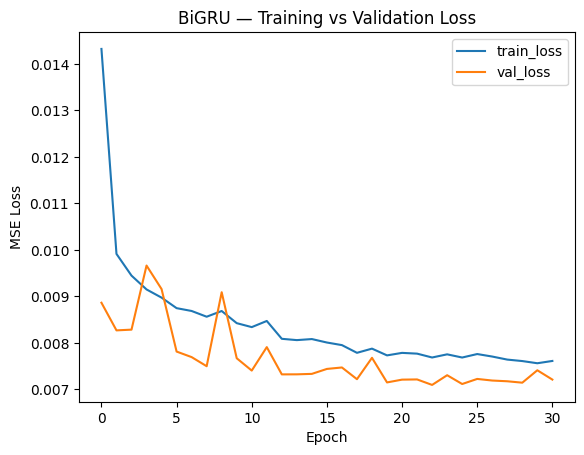

In [24]:
plt.figure()
plt.plot(history_bigru.history["loss"], label="train_loss")
plt.plot(history_bigru.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("BiGRU — Training vs Validation Loss")
plt.show()


## Step 15 — Evaluate BiGRU and Compare with BiLSTM

We compute metrics in:
- scaled space
- original kW units

Then we print a side-by-side comparison table to pick the final best model for Flask.


In [25]:
# Load best BiGRU model
best_bigru = keras.models.load_model(
    "/kaggle/working/artifacts/model_cnn_bigru_sa.keras",
    custom_objects={"SelfAttention": SelfAttention}
)

# Predict
y_pred_bigru = best_bigru.predict(X_test, verbose=0)

# Scaled metrics
rmse_bigru = math.sqrt(mean_squared_error(y_test, y_pred_bigru))
mae_bigru  = mean_absolute_error(y_test, y_pred_bigru)
r2_bigru   = r2_score(y_test, y_pred_bigru)

# In original kW
y_pred_bigru_kw = inverse_target(scaler, y_pred_bigru, num_cols, t_idx)

rmse_bigru_kw = math.sqrt(mean_squared_error(y_test_kw, y_pred_bigru_kw))
mae_bigru_kw  = mean_absolute_error(y_test_kw, y_pred_bigru_kw)
r2_bigru_kw   = r2_score(y_test_kw, y_pred_bigru_kw)

# Comparison
comp = pd.DataFrame({
    "Model": ["CNN-BiLSTM-SA", "CNN-BiGRU-SA"],
    "RMSE_scaled": [rmse, rmse_bigru],
    "MAE_scaled":  [mae, mae_bigru],
    "R2_scaled":   [r2, r2_bigru],
    "RMSE_kW":     [rmse_kw, rmse_bigru_kw],
    "MAE_kW":      [mae_kw, mae_bigru_kw],
    "R2_kW":       [r2_kw, r2_bigru_kw]
})

display(comp)

# Save BiGRU metrics too
metrics_bigru = {
    "scaled": {"rmse": float(rmse_bigru), "mae": float(mae_bigru), "r2": float(r2_bigru)},
    "original_kw": {"rmse": float(rmse_bigru_kw), "mae": float(mae_bigru_kw), "r2": float(r2_bigru_kw)},
    "selected_features": selected_features,
    "lookback": LOOKBACK,
    "horizon": HORIZON
}

with open("/kaggle/working/artifacts/metrics_cnn_bigru_sa.json", "w") as f:
    json.dump(metrics_bigru, f, indent=2)

print("✅ Saved: /kaggle/working/artifacts/metrics_cnn_bigru_sa.json")


,Model,RMSE_scaled,MAE_scaled,R2_scaled,RMSE_kW,MAE_kW,R2_kW
0,CNN-BiLSTM-SA,0.072253,0.050977,0.562507,0.465060,0.328117,0.562507
1,CNN-BiGRU-SA,0.073396,0.052618,0.548556,0.472417,0.338677,0.548556


✅ Saved: /kaggle/working/artifacts/metrics_cnn_bigru_sa.json


## Step 16 — Finalize Best Model Artifacts

We pick the best-performing model: **CNN-BiLSTM-SA**.

We create a clean final artifact set for VS Code integration:
- final_model.keras
- scaler.pkl
- selected_features.json
- config.json
- metrics_final.json


In [26]:
import shutil, glob

ART = "/kaggle/working/artifacts"
os.makedirs(ART, exist_ok=True)

# Copy best model as final alias (easier for Flask)
src_model = f"{ART}/model_cnn_bilstm_sa.keras"
final_model = f"{ART}/final_model.keras"
shutil.copyfile(src_model, final_model)

# Copy BiLSTM metrics as final metrics
src_metrics = f"{ART}/metrics_cnn_bilstm_sa.json"
final_metrics = f"{ART}/metrics_final.json"
shutil.copyfile(src_metrics, final_metrics)

print("✅ Final artifacts created:")
print(" -", final_model)
print(" -", final_metrics)

# List what we have
print("\n📁 artifacts folder contents:")
for p in sorted(glob.glob(f"{ART}/*")):
    print(" -", os.path.basename(p))


✅ Final artifacts created:
 - /kaggle/working/artifacts/final_model.keras
 - /kaggle/working/artifacts/metrics_final.json

📁 artifacts folder contents:
 - config.json
 - final_model.keras
 - metrics_cnn_bigru_sa.json
 - metrics_cnn_bilstm_sa.json
 - metrics_final.json
 - model_cnn_bigru_sa.keras
 - model_cnn_bilstm_sa.keras
 - scaler.pkl
 - selected_features.json


## Step 17 — Zip Artifacts for Download

Kaggle makes it easiest if everything is packaged into a single ZIP.
We generate:

- `electricity_forecasting_artifacts.zip`

Then you download from Kaggle Output panel.


In [27]:
import zipfile

zip_path = "/kaggle/working/electricity_forecasting_artifacts.zip"
files_to_zip = [
    "/kaggle/working/artifacts/final_model.keras",
    "/kaggle/working/artifacts/scaler.pkl",
    "/kaggle/working/artifacts/selected_features.json",
    "/kaggle/working/artifacts/config.json",
    "/kaggle/working/artifacts/metrics_final.json",
]

with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for fpath in files_to_zip:
        if os.path.exists(fpath):
            z.write(fpath, arcname=os.path.basename(fpath))
        else:
            print("⚠️ Missing (not zipped):", fpath)

print("✅ ZIP created:", zip_path)
print("➡️ Kaggle: Right sidebar → Output → Download electricity_forecasting_artifacts.zip")


✅ ZIP created: /kaggle/working/electricity_forecasting_artifacts.zip
➡️ Kaggle: Right sidebar → Output → Download electricity_forecasting_artifacts.zip


## Step 18 — Quick Inference Test (Flask Simulation)

This verifies that:
- model loads correctly
- scaler + feature order works
- prediction pipeline runs using the latest `lookback` window

We simulate how Flask will work:
- take last 24 rows
- scale using saved scaler
- predict next-hour Global_active_power
- inverse transform to kW


In [28]:
# Load final artifacts
scaler_loaded = joblib.load("/kaggle/working/artifacts/scaler.pkl")
with open("/kaggle/working/artifacts/selected_features.json") as f:
    feats = json.load(f)
with open("/kaggle/working/artifacts/config.json") as f:
    cfg = json.load(f)

lookback = int(cfg["lookback"])
target_col = cfg["target_col"]
all_cols_live = feats + [target_col]

# Load final model
final_loaded = keras.models.load_model(
    "/kaggle/working/artifacts/final_model.keras",
    custom_objects={"SelfAttention": SelfAttention}
)

# Prepare last window from df_hourly (unscaled)
last_block = df_hourly[all_cols_live].iloc[-lookback:].values  # (24, 6)
last_scaled = scaler_loaded.transform(last_block)              # (24, 6)

X_live = last_scaled.reshape(1, lookback, last_scaled.shape[1])  # (1,24,6)

pred_scaled = final_loaded.predict(X_live, verbose=0).reshape(-1, 1)

# Inverse-transform to kW using dummy array trick
num_cols_live = len(all_cols_live)
t_idx_live = num_cols_live - 1

pred_kw = inverse_target(scaler_loaded, pred_scaled, num_cols_live, t_idx_live)[0]

print("✅ Flask-style inference test passed.")
print("Predicted next-hour Global_active_power (kW):", float(pred_kw))


✅ Flask-style inference test passed.
Predicted next-hour Global_active_power (kW): 0.7821608781814575


In [29]:
# ✅ SINGLE-CELL: Generate ALL thesis figures + ZIP download (Kaggle-ready)
# Assumes these exist from your previous steps:
# history, history_bigru, y_test, y_pred, y_test_kw, y_pred_kw, mi_df
# If comp doesn't exist, it will be created from your metrics.

import os, json, glob, zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

FIG_DIR = "/kaggle/working/figures"
os.makedirs(FIG_DIR, exist_ok=True)

def savefig(name):
    path = os.path.join(FIG_DIR, name)
    plt.tight_layout()
    plt.savefig(path, dpi=300, bbox_inches="tight")
    plt.close()
    print("✅ Saved:", path)

# ---------------------------
# Build/ensure comp DataFrame
# ---------------------------
try:
    comp  # if already exists from your notebook
except NameError:
    comp = pd.DataFrame({
        "Model": ["CNN-BiLSTM-SA", "CNN-BiGRU-SA"],
        "RMSE_scaled": [0.072253, 0.073396],
        "MAE_scaled":  [0.050977, 0.052618],
        "R2_scaled":   [0.562507, 0.548556],
        "RMSE_kW":     [0.465060, 0.472417],
        "MAE_kW":      [0.328117, 0.338677],
        "R2_kW":       [0.562507, 0.548556],
    })

# ---------------------------
# 1) Model comparison table image
# ---------------------------
fig, ax = plt.subplots(figsize=(12, 2.2))
ax.axis("off")
tbl = ax.table(
    cellText=np.round(comp.drop(columns=["Model"]).values, 6),
    colLabels=comp.drop(columns=["Model"]).columns,
    rowLabels=comp["Model"].values,
    loc="center"
)
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1, 1.4)
plt.title("Model Performance Comparison", pad=10)
savefig("Fig_Model_Comparison_Table.png")

# ---------------------------
# 2) Model comparison bar charts
# ---------------------------
models = comp["Model"].values

plt.figure(figsize=(7,4))
plt.bar(models, comp["RMSE_kW"].values)
plt.ylabel("RMSE (kW)")
plt.title("RMSE Comparison (kW)")
savefig("Fig_Compare_RMSE_kW.png")

plt.figure(figsize=(7,4))
plt.bar(models, comp["MAE_kW"].values)
plt.ylabel("MAE (kW)")
plt.title("MAE Comparison (kW)")
savefig("Fig_Compare_MAE_kW.png")

plt.figure(figsize=(7,4))
plt.bar(models, comp["R2_kW"].values)
plt.ylabel("R²")
plt.title("R² Comparison (kW)")
savefig("Fig_Compare_R2_kW.png")

# ---------------------------
# 3) Training curves (BiLSTM + BiGRU)
# ---------------------------
# BiLSTM
plt.figure(figsize=(7,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CNN-BiLSTM-SA — Training vs Validation Loss")
plt.legend()
savefig("Fig_Loss_CNN_BiLSTM_SA.png")

# BiGRU
plt.figure(figsize=(7,4))
plt.plot(history_bigru.history["loss"], label="train_loss")
plt.plot(history_bigru.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("CNN-BiGRU-SA — Training vs Validation Loss")
plt.legend()
savefig("Fig_Loss_CNN_BiGRU_SA.png")

# ---------------------------
# 4) Actual vs Predicted (Scaled + kW) — first N
# ---------------------------
N = 300
y_test_s = np.array(y_test).reshape(-1)
y_pred_s = np.array(y_pred).reshape(-1)
y_test_kw_s = np.array(y_test_kw).reshape(-1)
y_pred_kw_s = np.array(y_pred_kw).reshape(-1)

plt.figure(figsize=(10,4))
plt.plot(y_test_s[:N], label="Actual")
plt.plot(y_pred_s[:N], label="Predicted")
plt.xlabel("Time step")
plt.ylabel("Scaled Global_active_power")
plt.title("Actual vs Predicted (Scaled) — First 300 Test Points")
plt.legend()
savefig("Fig_Actual_vs_Pred_Scaled_First300.png")

plt.figure(figsize=(10,4))
plt.plot(y_test_kw_s[:N], label="Actual (kW)")
plt.plot(y_pred_kw_s[:N], label="Predicted (kW)")
plt.xlabel("Time step")
plt.ylabel("Global_active_power (kW)")
plt.title("Actual vs Predicted (kW) — First 300 Test Points")
plt.legend()
savefig("Fig_Actual_vs_Pred_kW_First300.png")

# ---------------------------
# 5) Residual analysis (kW)
# ---------------------------
res = y_test_kw_s - y_pred_kw_s

M = min(1000, len(res))
plt.figure(figsize=(10,4))
plt.plot(res[:M])
plt.axhline(0)
plt.xlabel("Time step")
plt.ylabel("Residual (kW)")
plt.title("Residuals Over Time (kW) — First 1000 Test Points")
savefig("Fig_Residuals_Time_kW.png")

plt.figure(figsize=(7,4))
plt.hist(res, bins=60)
plt.xlabel("Residual (kW)")
plt.ylabel("Frequency")
plt.title("Residual Distribution (kW)")
savefig("Fig_Residuals_Hist_kW.png")

# ---------------------------
# 6) Scatter: Predicted vs Actual (kW)
# ---------------------------
plt.figure(figsize=(6,6))
plt.scatter(y_test_kw_s, y_pred_kw_s, s=6, alpha=0.4)
mn = float(min(y_test_kw_s.min(), y_pred_kw_s.min()))
mx = float(max(y_test_kw_s.max(), y_pred_kw_s.max()))
plt.plot([mn, mx], [mn, mx], linestyle="--")
plt.xlabel("Actual (kW)")
plt.ylabel("Predicted (kW)")
plt.title("Predicted vs Actual (kW)")
savefig("Fig_Scatter_Pred_vs_Actual_kW.png")

# ---------------------------
# 7) Feature relevance plot (MI ranking)
# ---------------------------
# If mi_df is missing, we create it from your selected MI scores (based on your output).
try:
    mi_df
except NameError:
    mi_df = pd.DataFrame({
        "feature": ["Global_intensity", "Sub_metering_3", "Voltage", "Global_reactive_power", "Sub_metering_2", "Sub_metering_1"],
        "MI": [3.242534, 0.655366, 0.202940, 0.173717, 0.172238, 0.153720]
    })

plt.figure(figsize=(8,4))
plt.bar(mi_df["feature"].values, mi_df["MI"].values)
plt.xticks(rotation=20, ha="right")
plt.ylabel("Mutual Information")
plt.title("Feature Relevance (Mutual Information vs Target)")
savefig("Fig_Feature_MI_Ranking.png")

# ---------------------------
# 8) ZIP all figures
# ---------------------------
zip_fig = "/kaggle/working/thesis_figures.zip"
with zipfile.ZipFile(zip_fig, "w", compression=zipfile.ZIP_DEFLATED) as z:
    for p in sorted(glob.glob(f"{FIG_DIR}/*.png")):
        z.write(p, arcname=os.path.basename(p))

print("\n✅ All figures generated in:", FIG_DIR)
print("✅ Zipped figures:", zip_fig)
print("➡️ Kaggle Output panel → Download thesis_figures.zip")


✅ Saved: /kaggle/working/figures/Fig_Model_Comparison_Table.png
✅ Saved: /kaggle/working/figures/Fig_Compare_RMSE_kW.png
✅ Saved: /kaggle/working/figures/Fig_Compare_MAE_kW.png
✅ Saved: /kaggle/working/figures/Fig_Compare_R2_kW.png
✅ Saved: /kaggle/working/figures/Fig_Loss_CNN_BiLSTM_SA.png
✅ Saved: /kaggle/working/figures/Fig_Loss_CNN_BiGRU_SA.png
✅ Saved: /kaggle/working/figures/Fig_Actual_vs_Pred_Scaled_First300.png
✅ Saved: /kaggle/working/figures/Fig_Actual_vs_Pred_kW_First300.png
✅ Saved: /kaggle/working/figures/Fig_Residuals_Time_kW.png
✅ Saved: /kaggle/working/figures/Fig_Residuals_Hist_kW.png
✅ Saved: /kaggle/working/figures/Fig_Scatter_Pred_vs_Actual_kW.png
✅ Saved: /kaggle/working/figures/Fig_Feature_MI_Ranking.png

✅ All figures generated in: /kaggle/working/figures
✅ Zipped figures: /kaggle/working/thesis_figures.zip
➡️ Kaggle Output panel → Download thesis_figures.zip
